# Assignment 8

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt

torch.__version__

'1.2.0'

## Load test data and add noises 

In [2]:
class numpyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = torch.from_numpy(data).float()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x
    
    def __len__(self):
        return len(self.data)

    
def activateNoises(imagedata, std_dev):
    noisedata = imagedata + np.random.normal(0, std_dev, imagedata.shape)
    
    noisedata = np.minimum(noisedata, 1)
    noisedata = np.maximum(noisedata, 0)
    
    return noisedata

In [3]:
noises = [0.01, 0.02, 0.03, 0.04]

transform       = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor(),
                            ])

# for training
traindata       = np.load('data/train.npy')
noisedata       = activateNoises(traindata, 0.025)

valdata         = traindata[4000:,:,:]
traindata       = traindata[:4000,:,:]

noise_valdata   = noisedata[4000:,:,:]
noisedata       = noisedata[:4000,:,:]


traindataset    = numpyDataset(traindata, transform)
noisedataset    = numpyDataset(noisedata, transform)
valdataset      = numpyDataset(valdata, transform)
noise_valdataset= numpyDataset(noise_valdata, transform)


trainloader     = DataLoader(traindataset, batch_size=200, shuffle=False, num_workers=0)
noiseloader     = DataLoader(noisedataset, batch_size=200, shuffle=False, num_workers=0)
valloader       = DataLoader(valdataset, batch_size=100, shuffle=False, num_workers=0)
noise_valloader = DataLoader(noise_valdataset, batch_size=100, shuffle=False, num_workers=0)

In [4]:
print(traindata.shape)
print(noisedata.shape)
print(valdata.shape)
print(noise_valdata.shape)

(4000, 120, 80)
(4000, 120, 80)
(400, 120, 80)
(400, 120, 80)


## Define AutoEncoder

In [5]:
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 128, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(128, 32, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(32, 8, 3, stride=1, padding=1),
            nn.ReLU(True),
#             nn.MaxPool2d(2, stride=2),
            
#             nn.Conv2d(8, 1, 3, stride=1, padding=1),
#             nn.ReLU(True), 
        )
        self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(1, 8, 3, stride=1, padding=1),
#             nn.ReLU(True),
            
            nn.ConvTranspose2d(8, 32, 3, stride=1, padding=1),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(32, 128, 2, stride=2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(128, 1, 2, stride=2),
            nn.Tanh()
            
#             nn.ConvTranspose2d(8, 4, 2, stride=2, padding=0),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(4, 1, 2, stride=2, padding=0),

        )

    def forward(self, x):
        x = self.encoder(x)
#         print(x.shape)
        x = self.decoder(x)
#         print(x.shape)
        return x

In [6]:
model = AutoEncoder()

bCuda = 1

if bCuda:
    model.cuda()

optimizer   = optim.SGD(model.parameters(), lr=1e-1, weight_decay=1e-5)
objective   = nn.MSELoss()

def train():
    
    loss_train = []
    
    model.train()
    
    trainiter = iter(trainloader)
    
    for idx_batch, data in enumerate(noiseloader):
        
        original = trainiter.next()
        
        if bCuda:
            data = data.cuda()
            original = original.cuda()
        
        data = Variable(data)
        original = Variable(original)

        optimizer.zero_grad()
        output = model(data)
        
        loss = objective(output, original)
        loss.backward()
        optimizer.step()

        loss_train_batch = loss.item()
        loss_train.append(loss_train_batch)
    
    
    loss_train_mean = np.mean(loss_train)
    loss_train_std  = np.std(loss_train)
    
    return {'loss_train_mean': loss_train_mean, 'loss_train_std': loss_train_std }

def validation():
    
    loss_val = []
    
    model.eval()
    
    valiter = iter(valloader)
    
    for idx_batch, data in enumerate(noise_valloader):
        
        original = valiter.next()
        
        if bCuda:
            data = data.cuda()
            original = original.cuda()
            
        
        output  = model(data)
        loss    = objective(output, original)
        
        loss_val.append(loss.item())
        
    loss_val_mean = np.mean(loss_val)
    
    return {'loss_val_mean' : loss_val_mean, }

In [7]:
NUM_EPOCH = 100
loss_train_mean = []
loss_train_std = []
loss_val_mean = []

for epoch in trange(NUM_EPOCH):
        
    result_train = train()
    
    loss_train_mean.append(result_train['loss_train_mean'])
    loss_train_std.append(result_train['loss_train_std'])
    
    result_val = validation()
    
    loss_val_mean.append(result_val['loss_val_mean'])
    
    print("[epoch %5d] loss: (training) %0.5f  loss: (validation) %0.5f " % (epoch+1, result_train['loss_train_mean'], result_val['loss_val_mean']))

[epoch     1] loss: (training) 0.02097  loss: (validation) 0.01892 
[epoch     2] loss: (training) 0.01941  loss: (validation) 0.01889 
[epoch     3] loss: (training) 0.01939  loss: (validation) 0.01887 
[epoch     4] loss: (training) 0.01938  loss: (validation) 0.01885 
[epoch     5] loss: (training) 0.01936  loss: (validation) 0.01884 
[epoch     6] loss: (training) 0.01935  loss: (validation) 0.01882 
[epoch     7] loss: (training) 0.01933  loss: (validation) 0.01881 
[epoch     8] loss: (training) 0.01931  loss: (validation) 0.01879 
[epoch     9] loss: (training) 0.01929  loss: (validation) 0.01876 
[epoch    10] loss: (training) 0.01926  loss: (validation) 0.01873 
[epoch    11] loss: (training) 0.01922  loss: (validation) 0.01868 
[epoch    12] loss: (training) 0.01916  loss: (validation) 0.01861 
[epoch    13] loss: (training) 0.01906  loss: (validation) 0.01850 
[epoch    14] loss: (training) 0.01893  loss: (validation) 0.01836 
[epoch    15] loss: (training) 0.01878  loss: (v

In [8]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [9]:
# for training
testdata            = np.load('data/test.npy')
testdataset         = numpyDataset(testdata, transform)

noisetestdata       = activateNoises(testdata, 0.025)
noisetestdataset    = numpyDataset(noisetestdata, transform)

testloader          = DataLoader(testdataset, batch_size=64, shuffle=False, num_workers=0)
noisetestloader     = DataLoader(noisetestdataset, batch_size=64, shuffle=False, num_workers=0)

In [14]:
testiter = iter(testloader)
noiseiter = iter(noisetestloader)

In [15]:
original = testiter.next()
noises = noiseiter.next()

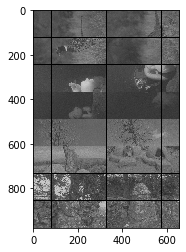

torch.Size([64, 1, 120, 80])
torch.Size([64, 1, 120, 80])


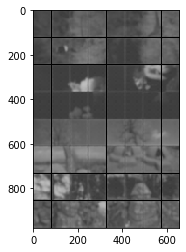

RuntimeError: Expected object of backend CPU but got backend CUDA for argument #2 'target'

In [16]:
original = testiter.next()
noises = noiseiter.next()

imshow(torchvision.utils.make_grid(original))
print(original.shape)

# imshow(torchvision.utils.make_grid(noises))
# print(noises.shape)

original = original.cuda()
noises = noises.cuda()

output = model(Variable(original))
print(output.shape)
output = output.cpu().detach()
imshow(torchvision.utils.make_grid(output))

loss = objective(output, original)
print(loss)

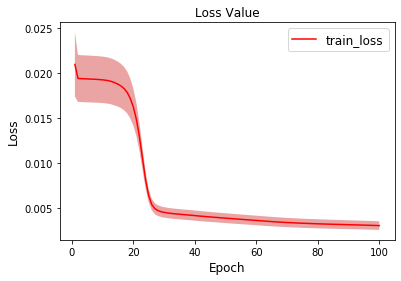

In [17]:
loss_std = np.array(loss_train_std)
train_loss = np.array(loss_train_mean)

plt.plot(range(1, len(train_loss)+1), train_loss,'-r', label='train_loss')
plt.fill_between(range(1, len(train_loss)+1), train_loss+loss_std, train_loss-loss_std, facecolor='#eba4a4')
plt.title("Loss Value")
plt.xlabel("Epoch", fontsize="12")
plt.ylabel("Loss", fontsize="12")
plt.legend(fontsize="12")

In [18]:
# for testing
testdata        = np.load('data/test.npy')
testdataset     = numpyDataset(testdata, transform)
testloader      = DataLoader(testdataset, batch_size=1, shuffle=False, num_workers=0)

result_for_submit = None    # this is for submit file


for batch_idx, data in enumerate(testloader):

        result_of_test = data

        if batch_idx == 0:
            result_for_submit = result_of_test
        else:
            try:
                result_for_submit = torch.cat([result_for_submit, result_of_test], dim=0)

            except RuntimeError:
                transposed = torch.transpose(result_of_test, 2, 3)
                result_for_submit = torch.cat([result_for_submit, transposed], dim=0)
        
# the submit_file.shape must be (400,1,120,80) 
submit_file = result_for_submit.detach().numpy()
np.save('GyeongHyeon_Kim.npy', submit_file)

In [30]:
submit = np.load('GyeongHyeon_Kim.npy')
print(submit.shape)

submit = numpyDataset(submit, transform)
submitloader = DataLoader(submit, batch_size=40, shuffle=False, num_workers=0)
subiter = iter(submitloader)

(400, 1, 120, 80)


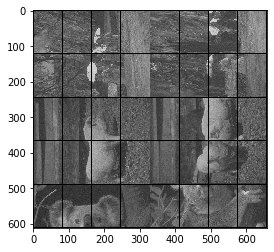

In [35]:

submit_img = subiter.next()
imshow(torchvision.utils.make_grid(submit_img))